In [1]:
import numpy as np
import pandas as pd
import random

# sklearn
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn import metrics
from sklearn.model_selection import train_test_split, cross_val_score, KFold

# Tensorflow
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

# Visualisation libraries

## matplotlib
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Polygon
import matplotlib.gridspec as gridspec
import matplotlib.colors
from pylab import rcParams
%matplotlib inline

## seaborn
import seaborn as sns
sns.set_context('paper', rc={'font.size':12,'axes.titlesize':14,'axes.labelsize':12})
sns.set_style('white')
plt.style.use('seaborn-whitegrid')

import warnings
warnings.filterwarnings("ignore")

## Keras Regression


Regression analysis is a set of statistical processes by which the relationships between a dependent variable and one or more independent variables are estimated. In this article, we use [scikit-learn Boston house-prices](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_boston.html) dataset for providing some examples for Keras regression. For more details, please see [Tensorflow tutorials](https://www.tensorflow.org/tutorials).

<div class="alert alert-block alert-success">
<font size="+2"><b>
Generating Data
</b></font>
</div>

Feature 1  Feature 2  Feature 3  Feature 4  Outcome Variable
0  -0.863920   1.003321  -3.423182  -0.682526         -0.991577
1  -1.756079  -0.787689  -2.948432  -5.061994         -2.638548
2  -2.019038  -2.292185  -2.819132  -0.816483         -1.986709
3  -1.618724  -3.584253  -4.430312  -1.399858         -2.758287
4  -0.230283   1.965946  -0.917975  -3.374862         -0.639293

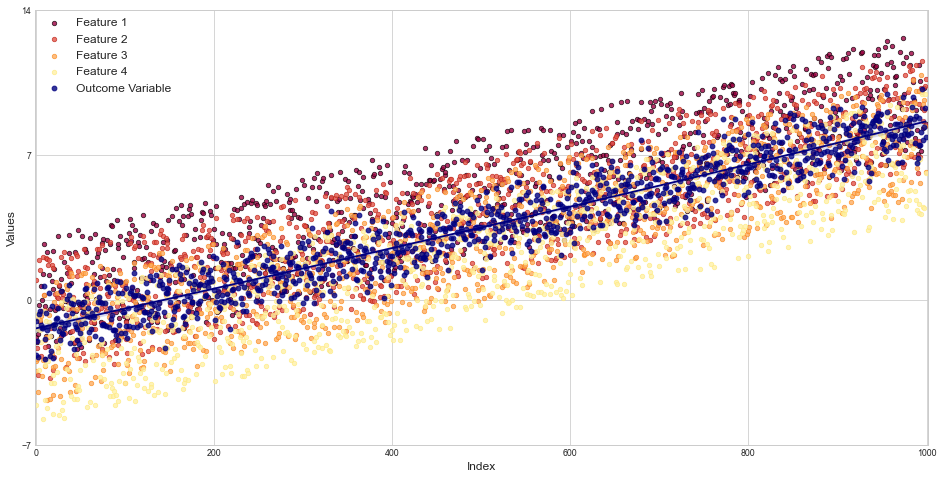

In [2]:
n_samples, n_features = 1000, 4

X = np.zeros([n_samples, n_features])
for i in range(n_features):
    X[:,i] = [((j/100) + random.uniform(-3,3) - i) for j in range(n_samples)]
    
y = np.mean(X, axis = 1)

Data = pd.DataFrame(data = X, columns = ['Feature %i' % (i+1) for i in range(n_features)])
Target = 'Outcome Variable'
Data[Target] = y

display(Data.head())
def lighten_color(color, amount=0.5):
    # This function, lighten_color, is taken from the following link
    # https://stackoverflow.com/questions/37765197/darken-or-lighten-a-color-in-matplotlib/49601444
    """
    Lightens the given color by multiplying (1-luminosity) by the given amount.
    Input can be matplotlib color string, hex string, or RGB tuple.

    Examples:
    >> lighten_color('g', 0.3)
    >> lighten_color('#F034A3', 0.6)
    >> lighten_color((.3,.55,.1), 0.5)
    """
    import matplotlib.colors as mc
    import colorsys
    try:
        c = mc.cnames[color]
    except:
        c = color
    c = colorsys.rgb_to_hls(*mc.to_rgb(c))
    return colorsys.hls_to_rgb(c[0], 1 - amount * (1 - c[1]), c[2])

ColorMap = matplotlib.cm.get_cmap('Spectral')
FC = [ColorMap(x*(0.15)) for x in np.arange(0, n_features)]
EC = [lighten_color(x, 1.4) for x in FC]

fig, ax = plt.subplots(figsize=(16,8))
for i in range(n_features):
    _ = ax.scatter(range(n_samples), X[:,i], s= 20, alpha = 0.8, facecolors=FC[i], edgecolors= EC[i],
                   label = 'Feature %i' % (i+1))
_ = sns.regplot(np.arange(n_samples), y=y, color="Navy", order = 2, ax = ax, label = Target)
_ = ax.set_xlabel('Index')
_ = ax.set_ylabel('Values')
_ = ax.set_xlim([-1, n_samples+1])
_ = ax.set_ylim([np.floor(ax.get_ylim()[0]), np.ceil(ax.get_ylim()[1])])
Temp = np.round(np.linspace(np.floor(ax.get_ylim()[0]), np.ceil(ax.get_ylim()[1]), num=4, retstep=True)[0],0)
Temp = np.sort(np.unique(np.append(Temp,0)))
_ = ax.set_yticks(Temp)
_ = ax.legend(fancybox=True, framealpha= 1, shadow=True, borderpad= 0.1, loc='best', fontsize = 12)

In [3]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

pd.DataFrame(data={'Set':['X_train','X_test','y_train','y_test'],
               'Shape':[X_train.shape, X_test.shape, y_train.shape, y_test.shape]}).set_index('Set').T

Set     X_train    X_test y_train  y_test
Shape  (700, 4)  (300, 4)  (700,)  (300,)

# Modeling

## Model 01: Regression using MLP Model

Model: "Keras_MLP_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 4)                 20        
_________________________________________________________________
dropout (Dropout)            (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 5         
Total params: 25
Trainable params: 25
Non-trainable params: 0
_________________________________________________________________


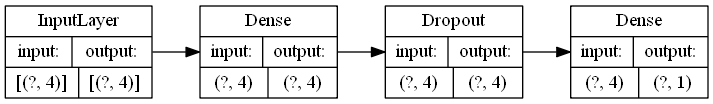

In [4]:
def Kmodel():
    model = keras.Sequential(name = "Keras_MLP_Model")
    model.add(layers.Dense(X.shape[1], input_dim= X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Kmodel().summary(line_length=None, positions=None, print_fn=None)
tf.keras.utils.plot_model(Kmodel(), show_shapes=True, show_layer_names=False, expand_nested = True, rankdir = 'LR')

Fitting the model:

In [5]:
IT = int(1e2)
kreg = keras.wrappers.scikit_learn.KerasRegressor(build_fn = Kmodel, epochs = IT, batch_size = X.shape[1], verbose=0)
_ = kreg.fit(X_train, y_train)

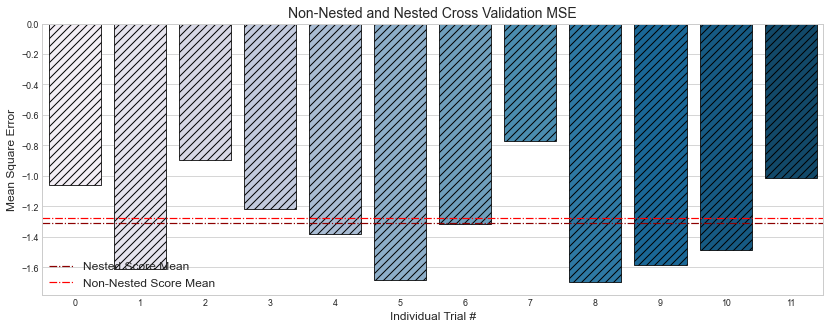

In [6]:
def Scores(clf, X_test = X_test, y_test = y_test):
    Kf = KFold(n_splits=12)
    y_pred = clf.predict(X_test)
    nested_score = cross_val_score(clf, X_test, y_test, cv= Kf)

    fig, ax = plt.subplots(figsize=(14,5))
    _ = sns.barplot(ax = ax, x=np.arange(len(nested_score)), y=nested_score, palette='PuBu',
                    edgecolor='k',  hatch="///")
    Temp = ax.get_xlim()
    _ = ax.hlines(y = nested_score.mean(), xmin = Temp[0], xmax = Temp[1], color = 'DarkRed',
                  linestyles='dashdot', label='Nested Score Mean')
    _ = ax.hlines(y = clf.score(X_test, y_test), xmin = Temp[0], xmax = Temp[1], color = 'Red',
                  linestyles='dashdot', label='Non-Nested Score Mean')
    _ = ax.set_xlim(Temp)
    _ = ax.legend(fancybox=True, framealpha= 1, shadow=True, borderpad= 0.1, loc='best', fontsize = 12)
    _ = ax.set_title('Non-Nested and Nested Cross Validation MSE')
    _ = ax.set_xlabel('Individual Trial #')
    _ = ax.set_ylabel('Mean Square Error')
    
Scores(kreg)

Other metrics,

In [7]:
def Metrics(y_pred, y_test):
    return pd.DataFrame({'explained_variance' : [metrics.explained_variance_score(y_pred, y_test)],
                         'max_error' : [metrics.max_error(y_pred, y_test)],
                        'neg_mean_absolute_error' : [metrics.mean_absolute_error(y_pred, y_test)],
                        'neg_mean_squared_error' : [metrics.mean_squared_error(y_pred, y_test)],
                        'r2' : [metrics.r2_score(y_pred, y_test)]}, index = ['Value'])

y_pred = kreg.predict(X_test)
display(Metrics(y_pred, y_test).round(2))

explained_variance  max_error  neg_mean_absolute_error  \
Value                0.65       2.66                     0.95   

       neg_mean_squared_error    r2  
Value                    1.28  0.65

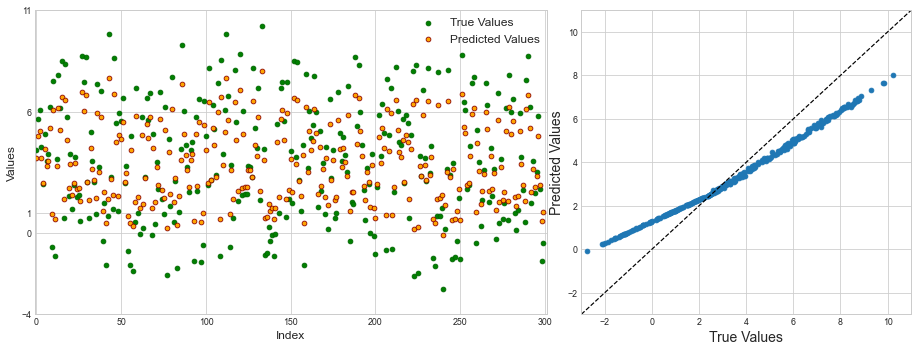

In [8]:
def TruePredPlot(y_test, y_pred):
    fig = plt.figure(figsize=(13, 5), constrained_layout=True)
    gs = fig.add_gridspec(1, 5)
    ax0 = fig.add_subplot(gs[:-2])
    ax1 = fig.add_subplot(gs[-2:])
    # Left
    _ = ax0.scatter(x = np.arange(y_test.shape[0]), y = y_test,
                   facecolors= 'Green', edgecolor= 'DarkGreen', label='True Values')
    _ = ax0.scatter(x = np.arange(y_test.shape[0]), y = y_pred,
                   facecolors= 'Orange', edgecolor= 'DarkRed', label='Predicted Values')
    _ = ax0.set_xlabel('Index')
    _ = ax0.set_ylabel('Values')
    _ = ax0.set_xlim([-1, y_test.shape[0]+1])
    _ = ax0.set_ylim([np.floor(ax0.get_ylim()[0]), np.ceil(ax0.get_ylim()[1])])
    Temp = np.round(np.linspace(np.floor(ax0.get_ylim()[0]), np.ceil(ax0.get_ylim()[1]), num=4, retstep=True)[0],0)
    Temp = np.sort(np.unique(np.append(Temp,0)))
    _ = ax0.set_yticks(Temp)
    _ = ax0.legend(fancybox=True, framealpha= 1, shadow=True, borderpad= 0.1, loc='best', fontsize = 12)
    plt.tight_layout()

    # Right
    _ = ax1.scatter(y_test, y_pred)
    N = int(np.max(np.ceil([np.max(y_test), np.max(y_pred)])))
    M = int(np.min(np.floor([np.min(y_test), np.min(y_pred)])))
    _ = ax1.plot([M, N], [M, N], '--k')
    _ = ax1.set_xlim([M, N])
    _ = ax1.set_ylim([M, N])
    del M, N
    _ = ax1.set_xlabel('True Values', fontsize=14)
    _ = ax1.set_ylabel('Predicted Values', fontsize=14)
    
TruePredPlot(y_test, y_pred)

## Model 02: Regression using MLP Model with Feature Scaling

### Standardizing features

We would like to standardize features by removing the mean and scaling to unit variance. In this article, we demonstrated the benefits of scaling data using [StandardScaler()](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html).

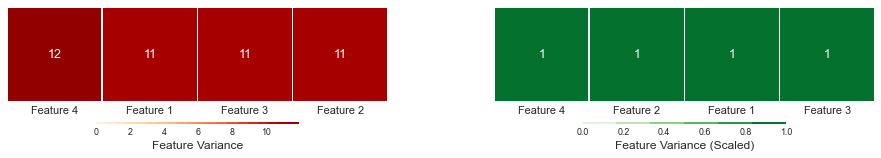

In [9]:
fig, ax = plt.subplots(1, 2, figsize=(16, 2.5))
Temp = Data.drop(columns = [Target]).var().sort_values(ascending = False).to_frame(name= 'Variance').round(2).T

_ = sns.heatmap(Temp, ax=ax[0], annot=True, square=True,  cmap =sns.color_palette("OrRd", 20),
                linewidths = 0.8, vmin=0, vmax=Temp.max(axis =1)[0], annot_kws={"size": 12.5},
                cbar_kws={'label': 'Feature Variance', "aspect":100, "shrink": .5, "orientation": "horizontal"})
_ = ax[0].set_xticklabels(ax[0].get_xticklabels(), fontsize = 11, rotation=0)
_ = ax[0].set_yticklabels('')

# Scaling
df = Data.copy()
Temp = df.drop(columns = Target).columns.tolist()
scaler = StandardScaler()
_ = scaler.fit(df[Temp])
df[Temp] = scaler.transform(df[Temp])

Temp = df.drop(columns = [Target]).var().sort_values(ascending = False).to_frame(name= 'Variance').round(2).T

_ = sns.heatmap(Temp, ax=ax[1], annot=True, square=True,  cmap =sns.color_palette('Greens'),
                linewidths = 0.8, vmin=0, vmax=Temp.max(axis =1)[0], annot_kws={"size": 12.5},
                cbar_kws={'label': 'Feature Variance (Scaled)', "aspect":100, "shrink": .5, "orientation": "horizontal"})
_ = ax[1].set_xticklabels(ax[1].get_xticklabels(), fontsize = 11, rotation=0)
_ = ax[1].set_yticklabels('')

Alternatively, we could implement this standardizing into a [pipeline](https://scikit-learn.org/stable/modules/generated/sklearn.pipeline.Pipeline.html). Thus,

In [10]:
pipeline = make_pipeline(StandardScaler(), kreg)
_ = pipeline.fit(X_train, y_train)

explained_variance  max_error  neg_mean_absolute_error  \
Value                0.78       2.11                     0.81   

       neg_mean_squared_error    r2  
Value                    0.91  0.78

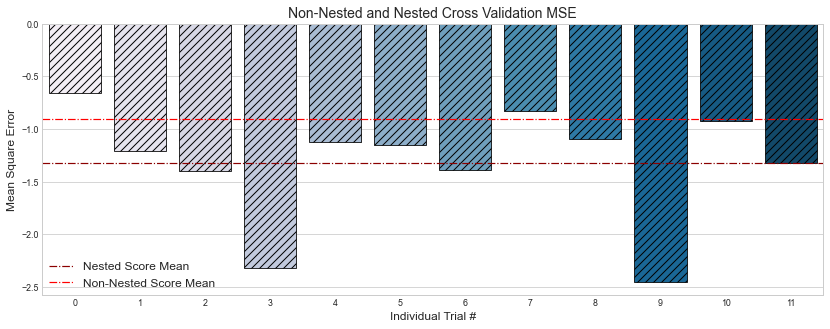

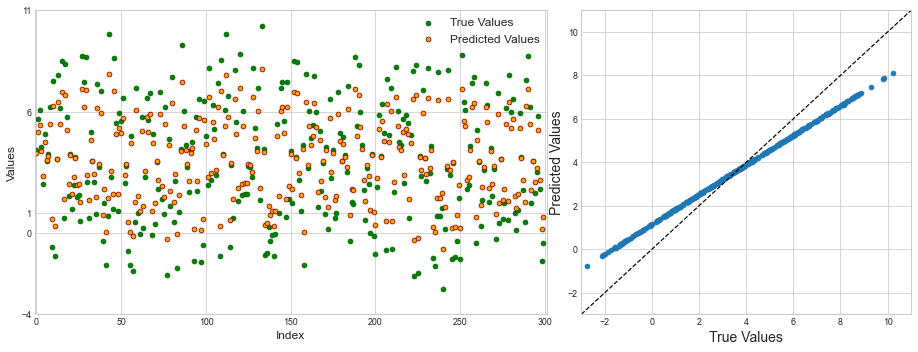

In [11]:
y_pred = pipeline.predict(X_test)
Scores(pipeline)
display(Metrics(y_pred, y_test).round(2))
TruePredPlot(y_test, y_pred)

## Model 03: Regression using MLP Model with Feature Scaling and More Layers

Model: "Keras_MLP_Model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_56 (Dense)             (None, 8)                 40        
_________________________________________________________________
dropout_28 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_57 (Dense)             (None, 4)                 36        
_________________________________________________________________
dropout_29 (Dropout)         (None, 4)                 0         
_________________________________________________________________
dense_58 (Dense)             (None, 1)                 5         
Total params: 81
Trainable params: 81
Non-trainable params: 0
_________________________________________________________________


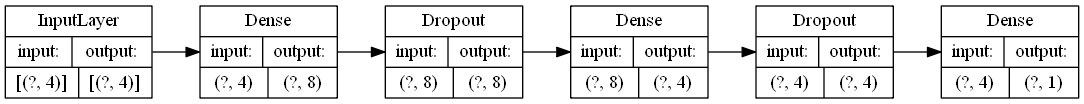

In [12]:
def Kmodel():
    model = keras.Sequential(name = "Keras_MLP_Model")
    model.add(layers.Dense(2*X.shape[1], input_dim= X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(X.shape[1], kernel_initializer='normal', activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(1, kernel_initializer='normal', activation='linear'))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

Kmodel().summary(line_length=None, positions=None, print_fn=None)
tf.keras.utils.plot_model(Kmodel(), show_shapes=True, show_layer_names=False, expand_nested = True, rankdir = 'LR')

Fitting the model:

In [13]:
IT = int(1e2)
kreg = keras.wrappers.scikit_learn.KerasRegressor(build_fn = Kmodel, epochs = IT, batch_size = X.shape[1], verbose=0)
_ = kreg.fit(X_train, y_train)

In [14]:
pipeline = make_pipeline(StandardScaler(), kreg)
_ = pipeline.fit(X_train, y_train)

explained_variance  max_error  neg_mean_absolute_error  \
Value                0.25       4.78                     1.16   

       neg_mean_squared_error    r2  
Value                    2.19  0.25

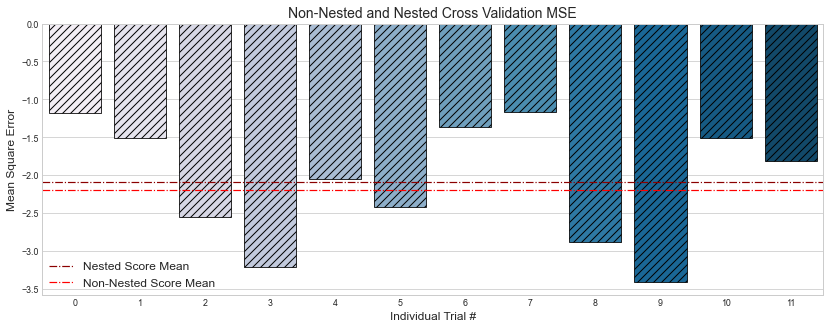

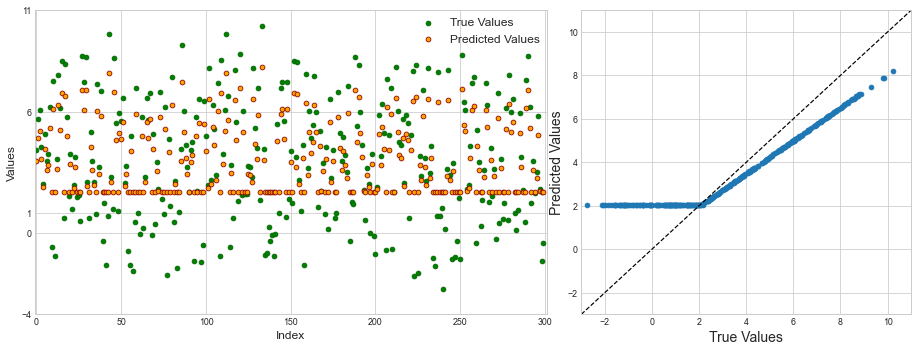

In [15]:
y_pred = pipeline.predict(X_test)
Scores(pipeline)
display(Metrics(y_pred, y_test).round(2))
TruePredPlot(y_test, y_pred)

# Conclusions

As can be seen, adding more complexity to the Keras model is not always beneficial. In our example, we can see a simple MLP model with Keras KerasRegressor when the data is scaled works the best.

***
# References

1. [Regression analysis wikipedia page](https://en.wikipedia.org/wiki/Regression_analysis)
1. [Keras developer guides](https://keras.io/guides/)
1. [Multilayer perceptron wikipedia page](https://en.wikipedia.org/wiki/Multilayer_perceptron)
1. [Confusion matrix wikipedia page](https://en.wikipedia.org/wiki/Multilayer_perceptron)

***